## Advanced Lane Finding Project
The goals / steps of this project are the following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Package Import

In [1]:
import os
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import data,color,morphology
%matplotlib inline

## Camera Calibration

### Compute the camera calibration using chessboard images
- Save the camera calibration result in `wide_dist_pickle.p` for later use

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open("./camera_cal/wide_dist_pickle.p", "wb"))

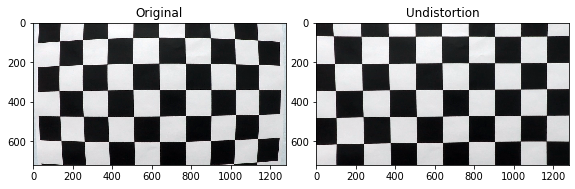

In [3]:
# Read in an image
img = cv2.imread('./camera_cal/calibration1.jpg')
dist_pickle = pickle.load(open("./camera_cal/wide_dist_pickle.p", "rb"))
# Undistort the image
dst = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])
# Save the image
if not os.path.exists('./output_images/CameraCalibration/'):
    os.mkdir('./output_images/CameraCalibration/')
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(dst)
ax2.set_title('Undistortion')
plt.subplots_adjust(left=0.05, bottom=0.02, right=0.98, top=1, wspace=0.12, hspace=0)
plt.savefig('./output_images/calibration1.jpg', dpi=100)

## Pipeline

### Distortion correction to raw images

In [4]:
def undistortion(img, dist_pickle):
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

### ROI selection

In [6]:
def roi(img, vertices, min_sz=50):    
    mask = np.zeros_like(img)
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    #roi_selected = morphology.remove_small_objects(masked_image.astype('bool'),min_size=min_sz,connectivity=2)    
    return masked_image #roi_selected.astype('uint8')

### Thresholded binary image
- Using combined gradient and color threshold to get binary image

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1   
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(30,170)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobely) + np.square(sobelx)) 
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    dir_binary = np.zeros_like(gradient_direction)
    dir_binary[(gradient_direction > thresh[0]) & (gradient_direction < thresh[1])] = 1
    return dir_binary

def color_select(img, channel='L', thresh=(0, 255)):        
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    # Apply a threshold to specific channel
    # HLS SPACE
    if channel == 'H':
        channel = hls[:,:,0]
    if channel == 'hls_L':
        channel = hls[:,:,1]
    if channel == 'S':
        channel = hls[:,:,2]
    # RGB SPACE
    if channel == 'R':
        channel = img[:,:,0]
    if channel == 'G':
        channel = img[:,:,1]
    if channel == 'rgb_B':
        channel = img[:,:,2]
     # LUV SPACE
    if channel == 'luv_L':
        channel = luv[:,:,0]
    if channel == 'U':
        channel = luv[:,:,1]
    if channel == 'V':
        channel = luv[:,:,2]
    # Lab SPACE
    if channel == 'lab_L':
        channel = lab[:,:,0]
    if channel == 'A':
        channel = lab[:,:,1]
    if channel == 'lab_B':
        channel = lab[:,:,2]
    
    color_binary = np.zeros_like(channel)
    color_binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # Return a binary image of threshold result
    return color_binary

def apply_thresh(img, ksize=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30,170))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

    color_binary_S = color_select(img, channel='S', thresh=(90, 255))
    color_binary_luvL = color_select(img, channel='luv_L', thresh=(215, 255))    
    color_binary_labB = color_select(img, channel='lab_B', thresh=(145, 200))
    color_binary_R = color_select(img, channel='R', thresh=(200, 255))
    
    # Combined threshold
    combined_output = np.zeros_like(gradx)
    combined_output[((gradx == 1) & (mag_binary == 1) & (dir_binary == 1)) | \
                    ((color_binary_S == 1) & (color_binary_luvL == 1)) | \
                    (color_binary_labB == 1)] = 1  #| (color_binary_R == 1)
    # Return a binary image of threshold result
    return combined_output

Note: If you read in an image using `matplotlib.image.imread()` you will get an `RGB` image, but if you read it in using OpenCV `cv2.imread()` this will give you a `BGR` image.

### Perspective transform

In [8]:
def bird_view(img):
    img_size = (img.shape[1],img.shape[0])
    
    # Define 4 source point
    src = np.float32(
        [[(img_size[0] / 2) - 62, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 62), img_size[1] / 2 + 100]])
    # Define 4 destination point
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])        

    # Get the perspective transform matrix M and inverse transform matrix Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Wrap the image to a bird view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

### Detect lane pixels and fit to find the lane boundary.

In [9]:
# Find the lane line and fit in pixels
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None
        self.best_fit_right = None
        #polynomial coefficients for the most recent fit
        self.current_fit_left =[]
        self.current_fit_right =[]
        #difference in fit coefficients between last and new fits
        self.diffs_left = np.array([0,0,0], dtype='float')
        self.diffs_right = np.array([0,0,0], dtype='float')
        #number of detected pixels
        #self.pixel_count = None
        
    def lanes_finder(self, img):
        if(not self.detected):            
            self.left_fit, self.right_fit, out_img = self.find_lane_pixels(img)
            self.detected = True
            return self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds, out_img
        else:
            self.left_fit, self.right_fit, out_img = self.search_around_poly(img, self.left_fit, self.right_fit)
            return self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds, out_img    

    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 10
        # Set the width of the windows +/- margin
        margin = 50
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2 ) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2 ) 

            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds)> minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds)> minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Fit a second order polynomial to each
        if len(leftx) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

    def search_around_poly(self, binary_warped, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 50

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        if len(leftx) != 0:
            left_fit_new = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit_new = np.polyfit(righty, rightx, 2)
            
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Color in left and right line pixels      
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, out_img
    
    def smooth_average(self, left_fit, right_fit, buffer_size=5):
        if (left_fit is not None) and (right_fit is not None):
            if (self.best_fit_left is not None) and (self.best_fit_right is not None): 
                self.diffs_left = abs(left_fit-self.best_fit_left)
                self.diffs_right = abs(right_fit-self.best_fit_right)
            if ((self.diffs_left[0] > 0.001 or self.diffs_right[0] > 0.001 or \
               self.diffs_left[1] > 1.0 or self.diffs_right[1] > 1.0 or \
               self.diffs_left[2] > 100 or self.diffs_right[2] > 100) and \
               (len(self.current_fit_left) > 0 or len(self.current_fit_right)) > 0):
                self.detected = False
            else:
                self.detected = True
                self.current_fit_left.append(left_fit)
                self.current_fit_right.append(right_fit)                
                if len(self.current_fit_left) > buffer_size:
                    self.current_fit_left = self.current_fit_left[len(self.current_fit_left)-buffer_size:]
                if len(self.current_fit_right) > buffer_size:
                    self.current_fit_right = self.current_fit_right[len(self.current_fit_right)-buffer_size:]
                self.best_fit_left = np.average(self.current_fit_left, axis=0)
                self.best_fit_right = np.average(self.current_fit_right, axis=0)
        else:
            self.detected = False
            if len(self.current_fit_left) > 0:
                self.current_fit_left = self.current_fit_left[:len(self.current_fit_left)-1]
            if len(self.current_fit_right) > 0:
                self.current_fit_right = self.current_fit_right[:len(self.current_fit_right)-1]
            if len(self.current_fit_left) > 0:
                self.best_fit_left = np.average(self.current_fit_left, axis=0)
            if len(self.current_fit_right) > 0:
                self.best_fit_right = np.average(self.current_fit_right, axis=0)

### Determine the curvature of the lane and vehicle position with respect to center

In [10]:
def measure_curvature_real(ploty, left_fit, right_fit, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
  
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)    
    # Calculation of R_curve (radius of curvature)
    left_curvature = np.sqrt((1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**3)/(2*np.abs(left_fit[0]))  ## Implement the calculation of the left line here
    right_curvature = np.sqrt((1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**3)/(2*np.abs(right_fit[0])) ## Implement the calculation of the right line here
    average_curvature = (left_curvature+right_curvature)/2    
    return average_curvature

def measure_vehicle_offset(img, ploty, left_fit, right_fit, xm_per_pix = 3.7/700):
    y_eval = np.max(ploty)
    left_line_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_line_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    center_of_lane = (left_line_x + right_line_x)/2
    offset = (img.shape[1]/2 - center_of_lane)*xm_per_pix
    return offset

### Warp the detected lane boundaries back onto the original image

In [11]:
def project_fit_lane(original, binary_warped, left_fit, right_fit, Minv):
    # Generate x and y values for plotting
    ploty = np.linspace(200, binary_warped.shape[0]-1, binary_warped.shape[0]-200)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(original).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0]), flags=cv2.INTER_LINEAR) 

    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)    
    return result

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [12]:
def project_fit_lane_info(img, average_curvature, offset):  
    direction = "right" if offset < 0 else "left"
    str_cur = "Radius of Curvature = {}(m)".format(int(average_curvature))
    str_offset = "Vehicle is {0:.2f}m ".format(abs(offset)) + "{} of center".format(direction)
    final_img = cv2.putText(img, str_cur, (30,40), 0, 1, (200,255,155), 2, cv2.LINE_AA)
    final_img = cv2.putText(img, str_offset, (30,70), 0, 1, (200,255,155), 2, cv2.LINE_AA)
    return final_img

### Test on images

D:\ProgramData\Anaconda3\envs\Zhao_tfv1\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
D:\ProgramData\Anaconda3\envs\Zhao_tfv1\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
D:\ProgramData\Anaconda3\envs\Zhao_tfv1\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
D:\ProgramData\Anaconda3\envs\Zhao_tfv1\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
D:\ProgramData\Anaconda3\envs\Zhao_tfv1\lib\site-packages\ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but 

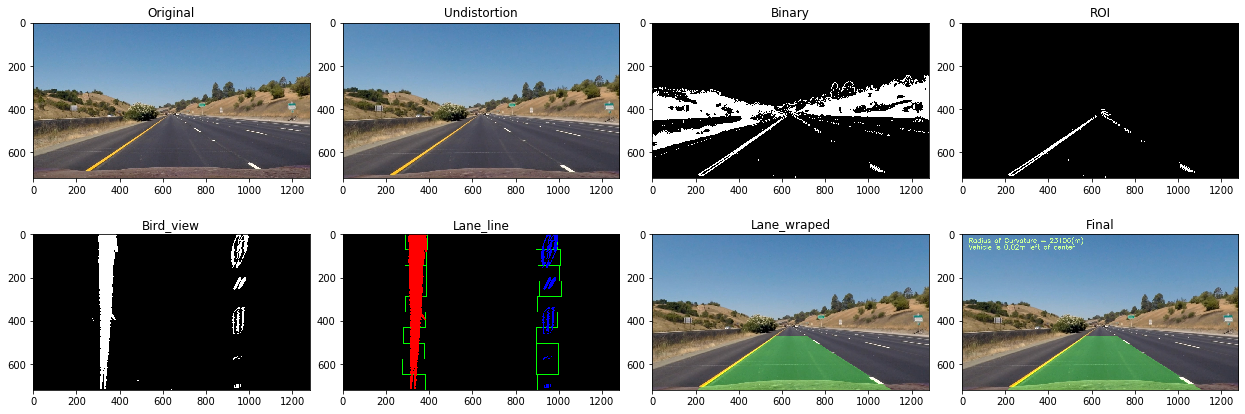

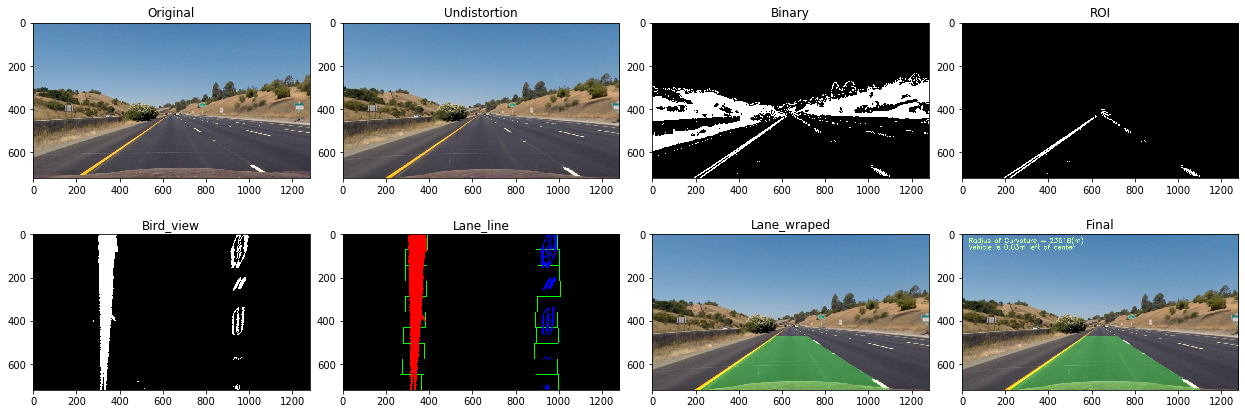

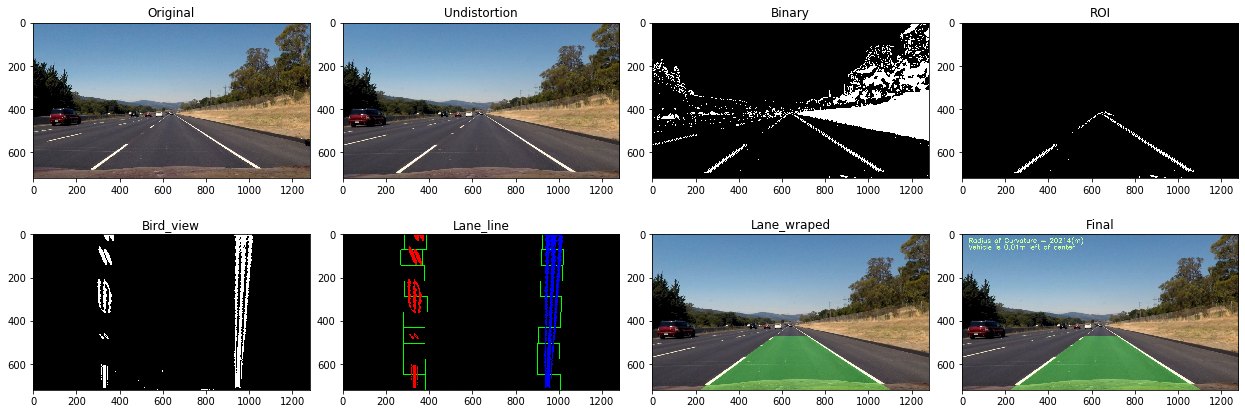

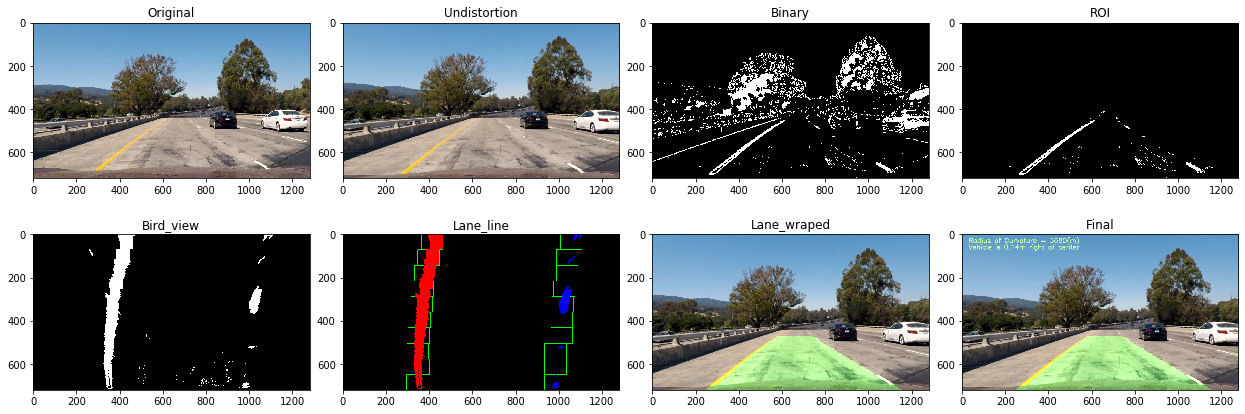

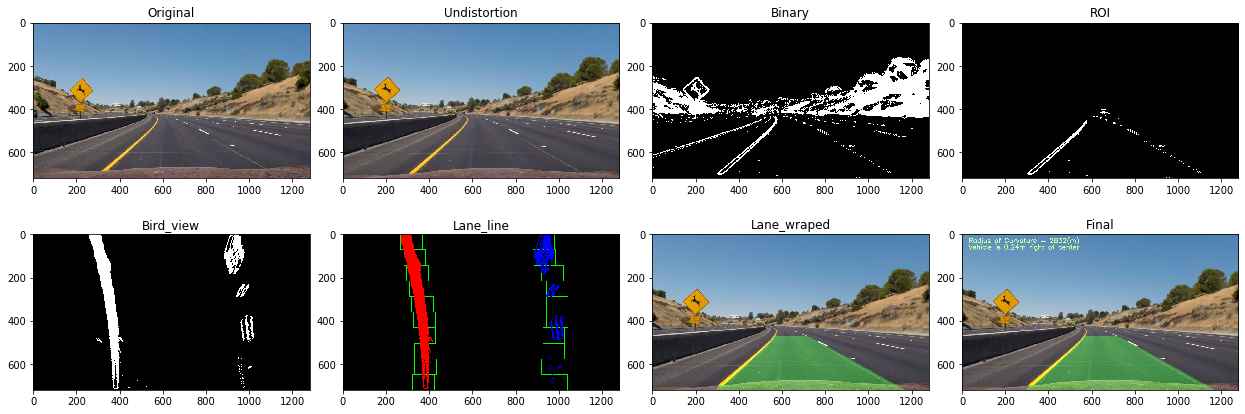

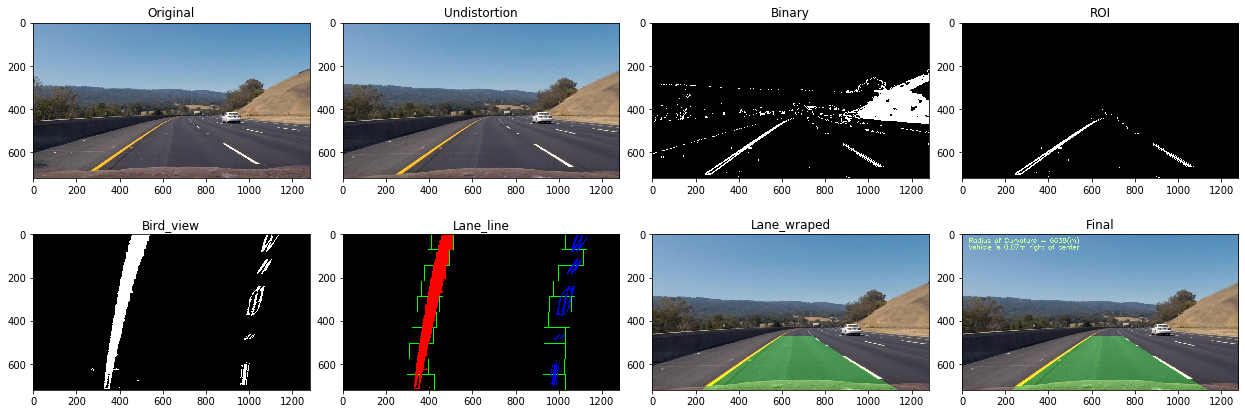

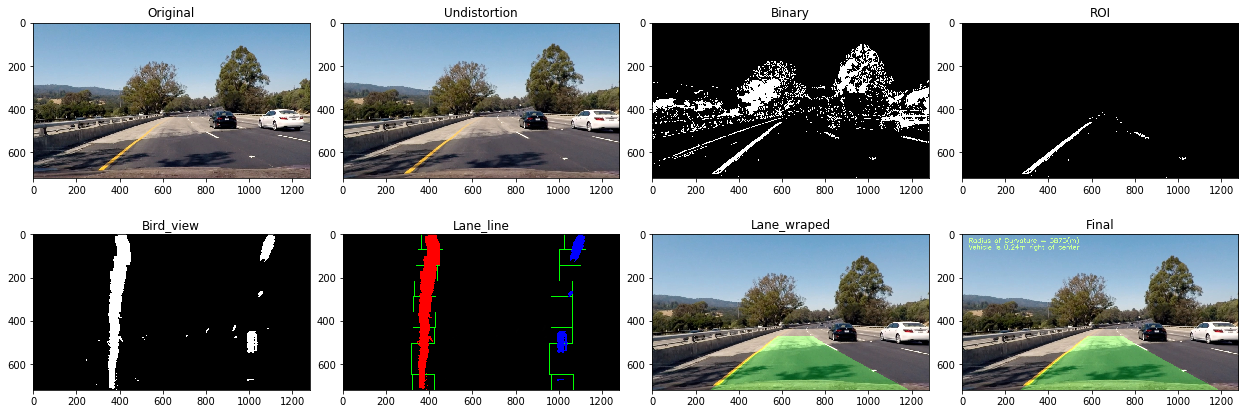

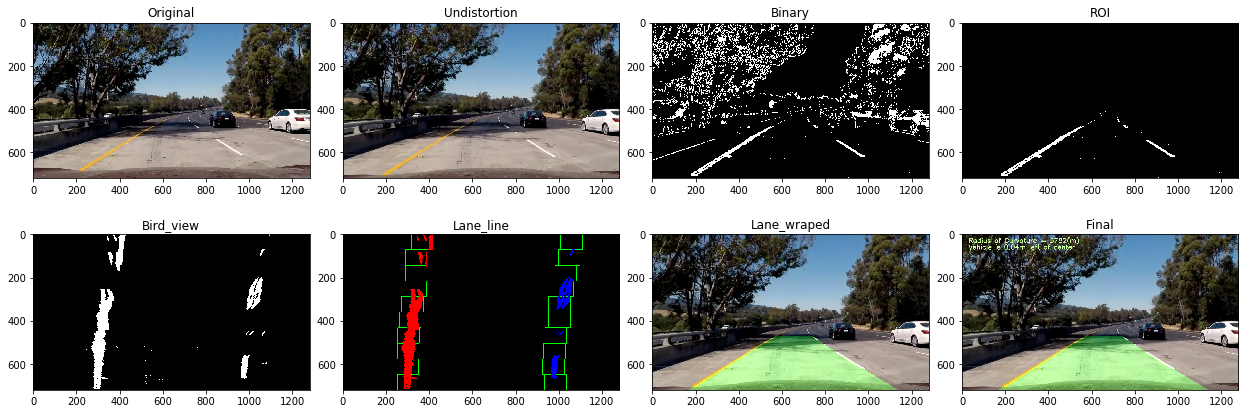

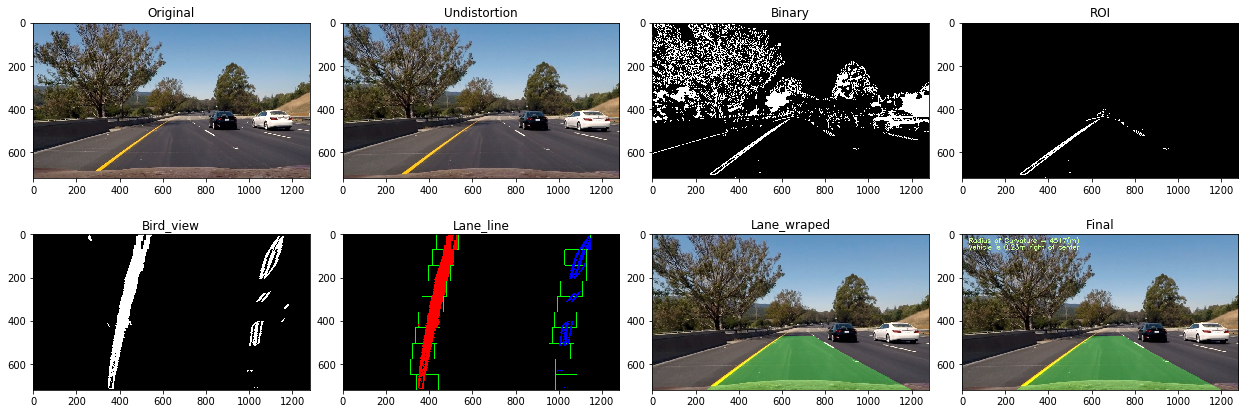

In [13]:
test_imgs = os.listdir("./test_images/")
for file in test_imgs:
    original_img = mpimg.imread("./test_images/"+file)
    
    # Undistort images
    dist_pickle = pickle.load(open("./camera_cal/wide_dist_pickle.p", "rb"))    
    undist_img = undistortion(original_img, dist_pickle)

    # Threshold
    binary_img = apply_thresh(undist_img, ksize=9)
   
    # ROI selection
    vertices = np.array([[(100,720),(669,400),(638,400),(1290,720)]],dtype=np.int32)
    roi_img = roi(binary_img, vertices)
        
    # Perspective transform
    bird_view_img, perspective_M, perspective_Minv = bird_view(roi_img)
    
    # Lane line detection
    L = Line()    
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = L.find_lane_pixels(bird_view_img)

    ploty = np.linspace(0, bird_view_img.shape[0]-1, bird_view_img.shape[0]) 
    wrap_lane_img =  project_fit_lane(undist_img, bird_view_img, left_fit, right_fit, perspective_Minv)
    
    average_curvature = measure_curvature_real(ploty, left_fit, right_fit)
    offset = measure_vehicle_offset(bird_view_img, ploty, left_fit, right_fit)
    final_img_input = np.copy(wrap_lane_img)
    final_img = project_fit_lane_info(final_img_input, average_curvature, offset)
    
    f, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2, 4, figsize=(18, 6))
    f.tight_layout()
    ax1.imshow(original_img)
    ax1.set_title('Original')
    ax2.imshow(undist_img)
    ax2.set_title('Undistortion')
    ax3.imshow(binary_img, cmap='gray')
    ax3.set_title('Binary')
    ax4.imshow(roi_img, cmap='gray')
    ax4.set_title('ROI')
    
    ax5.imshow(bird_view_img, cmap='gray')
    ax5.set_title('Bird_view')
    ax6.imshow(out_img)
    ax6.set_title('Lane_line')
    ax7.imshow(wrap_lane_img)
    ax7.set_title('Lane_wraped')
    ax8.imshow(final_img)
    ax8.set_title('Final')
    plt.subplots_adjust(left=0.05, bottom=0.02, right=0.98, top=1, wspace=0.12, hspace=0)
    plt.savefig('./output_images/' + file, dpi=100)

### Pipeline construction

In [14]:
def Lane_detector(img):
    undist_img = undistortion(img, dist_pickle)     
    binary_img = apply_thresh(undist_img, ksize=9)
    
    #ROI selection
    vertices = np.array([[(100,720),(545,470),(755,470),(1290,720)]],dtype=np.int32)
    roi_img = roi(binary_img, vertices)    
    
    bird_view_img, perspective_M, perspective_Minv = bird_view(roi_img)
    
    L = Line() 
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = L.find_lane_pixels(bird_view_img)
         
    L.smooth_average(left_fit, right_fit, buffer_size=3)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])    
    if (L.best_fit_left is not None) and (L.best_fit_right is not None):         
        average_curvature = measure_curvature_real(ploty, L.best_fit_left, L.best_fit_right)
        offset = measure_vehicle_offset(bird_view_img, ploty, L.best_fit_left, L.best_fit_right)
        wrap_lane_img =  project_fit_lane(undist_img, bird_view_img, L.best_fit_left, L.best_fit_right, perspective_Minv)
        project_fit_lane_info(wrap_lane_img, average_curvature, offset)
    else:
        wrap_lane_img = img
        average_curvature = measure_curvature_real(ploty, left_fit, right_fit)
        offset = measure_vehicle_offset(bird_view_img, ploty, left_fit, right_fit)
        wrap_lane_img =  project_fit_lane(undist_img, bird_view_img, left_fit, right_fit, perspective_Minv)
        project_fit_lane_info(wrap_lane_img, average_curvature, offset)  

    return wrap_lane_img

## Test on Videos

### Project video

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(30,35)
white_clip = clip1.fl_image(Lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 37min 15s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>?
""".format(white_output))

### Challenge video

In [16]:
white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(Lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/challenge_video.mp4.
Moviepy - Writing video test_videos_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video.mp4
Wall time: 14min 2s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
""".format(white_output))

### Harder challenge video

In [21]:
white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(Lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/harder_challenge_video.mp4.
Moviepy - Writing video test_videos_output/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/harder_challenge_video.mp4
Wall time: 35min 44s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))